# Генерация рецептов с помощью RNN (рекурентной нейронной сети)


In [1]:
import os
import pickle  #for saving trained model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
PATH_TO_DATA='../content/gdrive/My Drive/datasets/'

In [2]:
# подключаем гугл диск на котором данные
from google.colab import drive
drive.mount ('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/'My Drive'/datasets

author_quotes.txt		   RAW_recipes.csv
BIO_recipe_dataset.txt		   r_n.txt
ingredients01.csv		   war_and_peace_bpe_train.txt
ingredients05.csv		   war_and_peace.txt
ncep				   wildfires_check.csv
nyt-ingredients-head.csv	   wildfires_train.csv
nyt-ingredients-snapshot-2015.csv  wildfires_train.gsheet


In [4]:
data_df=pd.read_csv(PATH_TO_DATA+'ingredients01.csv',header=0)
data_df.head(10)

,"['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']"
0,"['prepared pizza crust', 'sausage patty', 'egg..."
1,"['ground beef', 'yellow onions', 'diced tomato..."
2,"['spreadable cheese with garlic and herbs', 'n..."
3,"['tomato juice', 'apple cider vinegar', 'sugar..."
4,"['milk', 'vanilla ice cream', 'frozen apple ju..."
5,"['fennel seeds', 'green olives', 'ripe olives'..."
6,"['pork spareribs', 'soy sauce', 'fresh garlic'..."
7,"['chocolate sandwich style cookies', 'chocolat..."
8,"['sugar', 'unsalted butter', 'bananas', 'eggs'..."
9,"['whole berry cranberry sauce', 'sour cream', ..."


In [5]:
data_df.columns=['Ingredients']

In [6]:
data_df.head()

,Ingredients
0,"['prepared pizza crust', 'sausage patty', 'egg..."
1,"['ground beef', 'yellow onions', 'diced tomato..."
2,"['spreadable cheese with garlic and herbs', 'n..."
3,"['tomato juice', 'apple cider vinegar', 'sugar..."
4,"['milk', 'vanilla ice cream', 'frozen apple ju..."


In [7]:
data_df.shape

(231636, 1)

In [8]:
names=data_df['Ingredients'][:2000]

In [ ]:
#with open(PATH_TO_DATA+'r_n.txt') as input_file:
#    names = input_file.read()[:-1].split('\n')
#    names = [' ' + line for line in names]

In [9]:
names[:5]

0    ['prepared pizza crust', 'sausage patty', 'egg...
1    ['ground beef', 'yellow onions', 'diced tomato...
2    ['spreadable cheese with garlic and herbs', 'n...
3    ['tomato juice', 'apple cider vinegar', 'sugar...
4    ['milk', 'vanilla ice cream', 'frozen apple ju...
Name: Ingredients, dtype: object

Посмотрим на распределение длин рецептов:

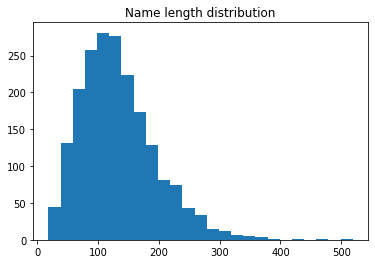

In [10]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25);

In [11]:
tokens_set=set()  #for tokens
good_data_list=[] #list for prepared data
for n in names:
  n=n[2:-2]
  temp=['START']  #THIS IS TECHNIKAL ELEMENT FOR MODEL TO START WITH
  temp.extend(list(map(str,n.split("', '"))))
  good_data_list.append(temp)


  #print(set(temp))
  tokens_set.update(set(temp))

In [12]:
good_data_list[:5]

[['START',
  'prepared pizza crust',
  'sausage patty',
  'eggs',
  'milk',
  'salt and pepper',
  'cheese'],
 ['START',
  'ground beef',
  'yellow onions',
  'diced tomatoes',
  'tomato paste',
  'tomato soup',
  'rotel tomatoes',
  'kidney beans',
  'water',
  'chili powder',
  'ground cumin',
  'salt',
  'lettuce',
  'cheddar cheese'],
 ['START',
  'spreadable cheese with garlic and herbs',
  'new potatoes',
  'shallots',
  'parsley',
  'tarragon',
  'olive oil',
  'red wine vinegar',
  'salt',
  'pepper',
  'red bell pepper',
  'yellow bell pepper'],
 ['START',
  'tomato juice',
  'apple cider vinegar',
  'sugar',
  'salt',
  'pepper',
  'clove oil',
  'cinnamon oil',
  'dry mustard'],
 ['START',
  'milk',
  'vanilla ice cream',
  'frozen apple juice concentrate',
  'apple']]

In [13]:
print(len(tokens_set),tokens_set)  #lets see the len of vocabulary and examples

2726 {'four-cheese mexican blend cheese', 'grenadine', 'hormel chili without beans', 'honey mustard', 'chocolate fudge frosting', 'rolls', 'corn chips', 'soya sauce', 'capers', 'miniature marshmallow', 'barley', 'cream', 'sandwich buns', 'bacon bits', 'lime-flavored vodka', 'dark cooking chocolate', 'meatloaf seasoning mix', 'malt vinegar', 'imitation crabmeat', 'fresh cream', '7-up soda', 'peppercorn', 'dried beef', 'cottage cheese with chives', 'jello gelatin', 'pitted ripe olives', 'dark chili powder', 'pork sirloin roast', 'brewed coffee', 'whipped topping', 'salsa', 'pak choi', 'red cinnamon candies', 'refried black beans', 'jumbo shrimp', 'chicken breast tenders', 'raspberry kool-aid', 'lemon, rind of', 'instant white chocolate pudding and pie filling mix', 'french roll', 'small shell pasta', 'prepared sweet-and-sour mix', 'self rising flour', 'fennel seeds', 'rhubarb', 'roasted red peppers', 'sunflower seeds', 'chocolate-covered peanuts', 'ground almonds', 'orange-flavored dark 

In [14]:
tokens=list(tokens_set)
print(tokens[:5])

['four-cheese mexican blend cheese', 'grenadine', 'hormel chili without beans', 'honey mustard', 'chocolate fudge frosting']


# Препроцессинг

In [15]:
#all unique characters go here
#tokens = list(set(''.join(names)))
#tokens = list(set(names))
num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  2726


### Символы -> id

Создадим словарь < ингридиент > -> < id >

In [16]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
#token_to_id={}
#cnt=0  #counter
#for elem in tokens:
#  token_to_id[elem]=cnt
#  cnt+=1

In [17]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems OK!")

Seems OK!


In [18]:
token_to_id['START']  #technical token to start with

979

In [19]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id['START']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [20]:
#Example: cast 4 names to matrices, pad with zeros
#print('\n'.join(names[::2000]))
#print(to_matrix(names[::2000], token_to_id))
#print(good_data_list)
print(to_matrix(good_data_list,token_to_id))

[[ 979  245 2425 ...  979  979  979]
 [ 979  643 1971 ...  979  979  979]
 [ 979 1806  353 ...  979  979  979]
 ...
 [ 979  878 2585 ...  979  979  979]
 [ 979  177 1458 ...  979  979  979]
 [ 979 1319 1621 ...  979  979  979]]


# Рекуррентные нейронные сети

<img src="img/rnn.png" width=480>

In [21]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [22]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(batch_size, self.num_units))

In [23]:
char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

In [24]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_index.transpose(0,1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [25]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

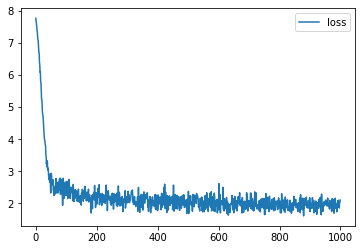

In [26]:
names=good_data_list
MAX_LENGTH = max(map(len, names))
for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация рецептов

In [27]:
def generate_sample(char_rnn, seed_phrase=['START'], max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return '*'.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [28]:
for _ in range(10):
    print(generate_sample(char_rnn))

START*romaine lettuce*cooked noodles*bulk sausage*prepared mustard*butterscotch chips*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*fat free sour cream*START
START*refried black beans*onion*snap peas*vegetable oil*cool whip*salt*salted peanuts*pecan pieces*ketchup*reduced-fat feta cheese*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START
START*egg*carrots*dried dill*carrot*italian seasoning*sugar*sesame seeds*garlic cloves*allspice*water*vegetable oil*START*START*START*START*START*mozzarella cheese*START*START*START*START*START*START*START*START*START*START*START
START*garlic*lemon juice*green peas*fresh ginger*ground turkey breast*chili pepper flakes*cinnamon*walnuts*celery*lemon juice*carrots*water*dry mustard*roma tomatoes*italian spices*all-purpose flour*START*START*START*START*START*START*START*START*START*START*START*START
START*rolled oats*garl

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [29]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=['START','milk']))

START*milk*egg*garlic cloves*START*butter*white vinegar*raisins*gouda cheese*salt and pepper*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START
START*milk*white chicken meat*monterey jack pepper cheese*green bell pepper*diced green chilies*apple*chicken broth*mayonnaise*bibb lettuce*brown sugar*pecans*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START
START*milk*baking soda*ketchup*vanilla*onion*green onion*raisins*nutmeg*stewed tomatoes*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START
START*milk*unsalted butter*coca-cola*cinnamon*START*bay leaf*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START*START
START*milk*splenda granular*light brown sugar*chicken breasts*dates*sugar*salt*fresh coarse ground black pepper*hard-boiled eggs*brown su

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [31]:
# save the model to disk
filename1 = 'finalized_char_rnn.pickle'
pickle.dump(char_rnn, open(filename1, 'wb'))

In [32]:
!ls

finalized_char_rnn.pickle  gdrive  sample_data


In [37]:
# save the model to disk
filename3 = 'finalized_token_to_id.pickle'
pickle.dump(token_to_id, open(filename3, 'wb'))

In [38]:
!ls

finalized_char_rnn.pickle	  finalized_token_to_id.pickle	sample_data
finalized_generate_sample.pickle  gdrive


In [35]:
from google.colab import files

files.download('finalized_char_rnn.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
from google.colab import files

files.download('finalized_token_to_id.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>